In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from models import get_model_from_run
from tasks import InductionHopsFullSequenceTask
import time
import pandas as pd
import seaborn as sns

/var/folders/67/jn51thvj1pb07505h888bfww0000gn/T/ipykernel_33313/630146141.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


**Note:** The below model directory paths can be modified to allow to point to directories in `models/induction_hops_full_seq` that correspond to your trained models.

In [2]:
depths = [2, 3, 4, 5, 6]
widths = [4, 8]
sample_counts = [1000, 3000, 10000, -1]


model_dir_names = {
    (2, 4, 1000): "width4-depth2-samples1k",
    (2, 4, 3000): "width4-depth2-samples3k",
    (2, 4, 10000): "width4-depth2-samples10k",
    (2, 4, -1): "width4-depth2",
    (2, 8, -1): "width8-depth2",
    (3, 4, 1000): "width4-depth3-samples1k",
    (3, 4, 3000): "width4-depth3-samples3k",
    (3, 4, 10000): "width4-depth3-samples10k",
    (3, 4, -1): "width4-depth3",
    (3, 8, -1): "width8-depth3",
    (4, 4, 1000): "width4-depth4-samples1k",
    (4, 4, 3000): "width4-depth4-samples3k",
    (4, 4, 10000): "width4-depth4-samples10k",
    (4, 4, -1): "width4-depth4",
    (4, 8, -1): "width8-depth4",
    (5, 4, 1000): "width4-depth5-samples1k",
    (5, 4, 3000): "width4-depth5-samples3k",
    (5, 4, 10000): "width4-depth5-samples10k",
    (5, 4, -1): "width4-depth5",
    (5, 8, -1): "width8-depth5",
    (6, 4, 1000): "width4-depth6-samples1k",
    (6, 4, 3000): "width4-depth6-samples3k",
    (6, 4, 10000): "width4-depth6-samples10k",
    (6, 4, -1): "width4-depth6",
    (6, 8, -1): "width8-depth6",
}

In [3]:
### ENTER YOUR DEVICE HERE
device = 'mps'

seq_len = 100

models = {}
for key, model_dir in model_dir_names.items():
    model_path = f"../models/induction_hops_full_seq/{model_dir}"
    models[key] = get_model_from_run(model_path, seq_len=seq_len, step=100000)[0].to(device)

max_hops = 16
rng = np.random.RandomState(0)

task = InductionHopsFullSequenceTask(seq_len, char_tokens=4, min_hops=0, max_hops=max_hops, rng=rng)


# Attention interpretability

In [12]:
num_samples = 10
input, _, _, _, _, hop_indices = task.get_batch(num_samples, metadata=True)
input = input.to(device)

inner_products = {}
remainders = {}

inner_product_means = {}
remainder_means = {}

attentions = {}

for key in models:
    t = time.time()
    for h in range(17):
        depth = key[0]
        width = key[1]
        input[:, 0] = h
        attns = models[key](input, output_attentions=True)[1]
        attentions[(h, key)] = [attn.detach().cpu().numpy() for attn in attns]
        # print(attentions[(h, key)])
    print(f"Evaluated model {key} in {time.time() - t:.2f} seconds")


Evaluated model (2, 4, 1000) in 1.50 seconds
Evaluated model (2, 4, 3000) in 0.14 seconds
Evaluated model (2, 4, 10000) in 0.14 seconds
Evaluated model (2, 4, -1) in 0.17 seconds
Evaluated model (2, 8, -1) in 0.35 seconds
Evaluated model (3, 4, 1000) in 0.23 seconds
Evaluated model (3, 4, 3000) in 0.31 seconds
Evaluated model (3, 4, 10000) in 0.23 seconds
Evaluated model (3, 4, -1) in 0.20 seconds
Evaluated model (3, 8, -1) in 0.34 seconds
Evaluated model (4, 4, 1000) in 0.29 seconds
Evaluated model (4, 4, 3000) in 0.27 seconds
Evaluated model (4, 4, 10000) in 0.26 seconds
Evaluated model (4, 4, -1) in 0.27 seconds
Evaluated model (4, 8, -1) in 0.37 seconds
Evaluated model (5, 4, 1000) in 0.31 seconds
Evaluated model (5, 4, 3000) in 0.31 seconds
Evaluated model (5, 4, 10000) in 0.30 seconds
Evaluated model (5, 4, -1) in 0.33 seconds
Evaluated model (5, 8, -1) in 0.56 seconds
Evaluated model (6, 4, 1000) in 0.41 seconds
Evaluated model (6, 4, 3000) in 0.38 seconds
Evaluated model (6, 4,

In [15]:
for key in models:
    t = time.time()
    for h in range(17):   
        depth = key[0]
        width = key[1]
        input[:, 0] = h
        for head in range(width):
            for layer in range(depth):
                for i in range(num_samples):
                    for h2 in range(17):
                        attention = attentions[(h, key)][layer][i, head]
                        h2_hop_matrix = np.zeros_like(attention)
                        indices_h2 = list(hop_indices[i][h2])[:-2]
                        for j in range(len(indices_h2)):
                            if indices_h2[j] != -1:
                                h2_hop_matrix[j+1, indices_h2[j] + 1] = 1

                        inner_products[(h, key, head, layer, h2, i)] = (attention * h2_hop_matrix).sum() / np.sqrt(h2_hop_matrix.sum() * (attention**2).sum())
                    
                    task_matrix = np.zeros_like(attention)
                    task_matrix[:, 0] = 1
                    inner_products[(h, key, head, layer, -1, i)] = (attention * task_matrix).sum() / np.sqrt(task_matrix.sum() * (attention**2).sum())
                
                    remainders[(h, key, head, layer, i)] = 1 - sum([inner_products[(h, key, head, layer, h2, i)] for h2 in range(-1, 17)])

                for h2 in range(-1, 17):
                    inner_product_means[(h, key, head, layer, h2)] = np.mean([inner_products[(h, key, head, layer, h2, i)] for i in range(num_samples)])
                remainder_means[(h, key, head, layer)] = np.mean([remainders[(h, key, head, layer, i)] for i in range(num_samples)])
    print(f"Computed inner products for model {key} in {time.time() - t:.2f} seconds")

Computed inner products for model (2, 4, 1000) in 0.66 seconds
Computed inner products for model (2, 4, 3000) in 0.66 seconds
Computed inner products for model (2, 4, 10000) in 0.66 seconds
Computed inner products for model (2, 4, -1) in 0.65 seconds
Computed inner products for model (2, 8, -1) in 1.34 seconds
Computed inner products for model (3, 4, 1000) in 0.96 seconds
Computed inner products for model (3, 4, 3000) in 0.96 seconds
Computed inner products for model (3, 4, 10000) in 0.98 seconds
Computed inner products for model (3, 4, -1) in 0.97 seconds
Computed inner products for model (3, 8, -1) in 1.95 seconds
Computed inner products for model (4, 4, 1000) in 1.29 seconds
Computed inner products for model (4, 4, 3000) in 1.29 seconds
Computed inner products for model (4, 4, 10000) in 1.35 seconds
Computed inner products for model (4, 4, -1) in 1.32 seconds
Computed inner products for model (4, 8, -1) in 2.62 seconds
Computed inner products for model (5, 4, 1000) in 1.67 seconds
C

## Plots of individual attention unit outputs

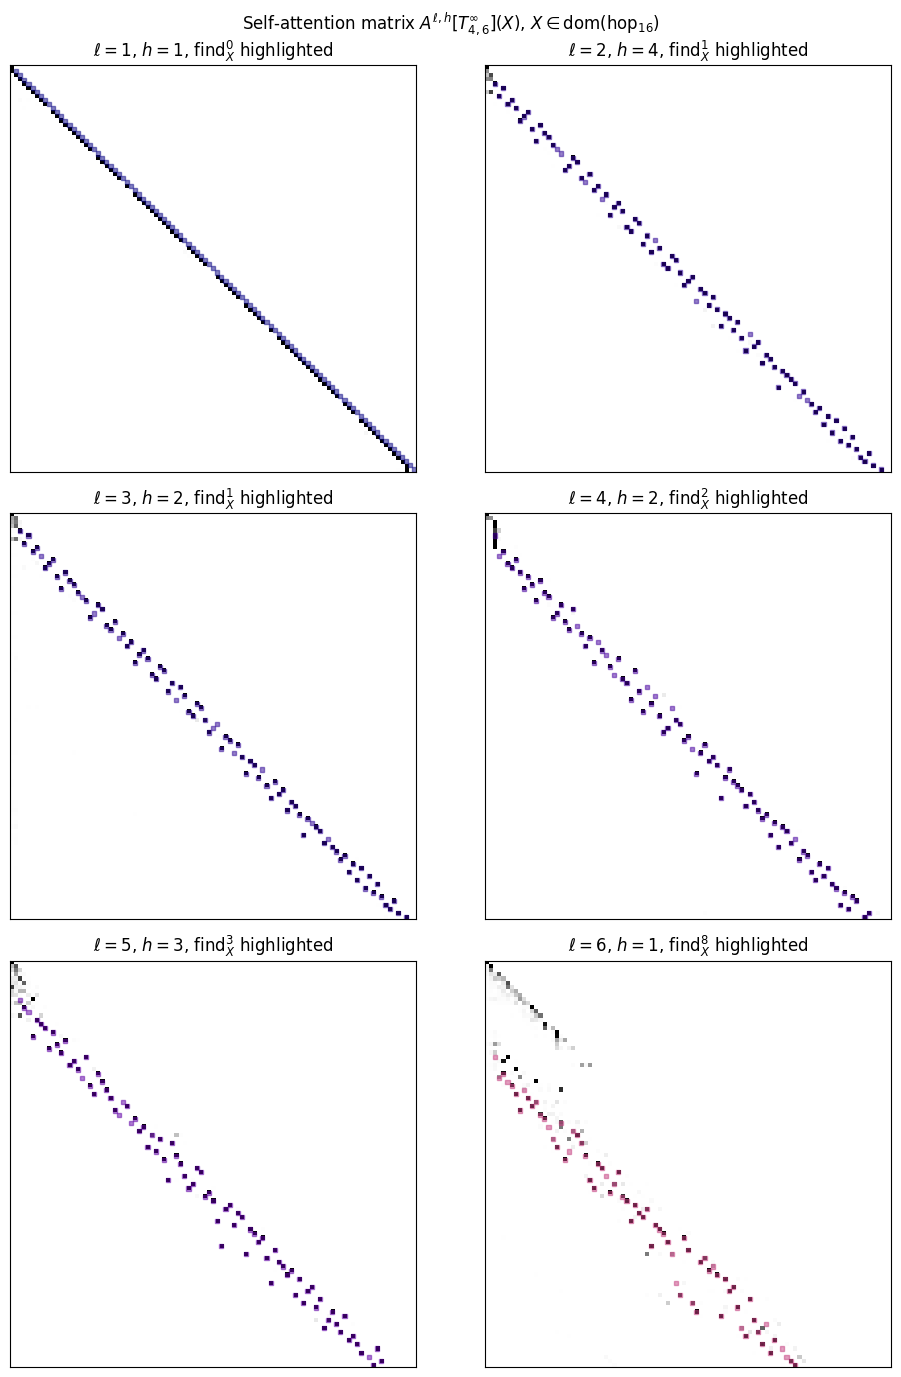

In [17]:
# same as above but for six different heads in a 3x2 grid
width = 4
depth = 6
samples = -1
layers = [0, 1, 2, 3, 4, 5]
heads = [0, 3, 1, 1, 2, 0]
include_errs = False
h = 16

find_fns_to_visualize = [[0], [1], [1], [2], [3], [8]]

key = (depth, width, samples)


fig, ax = plt.subplots(3, 2, figsize=(10, 14))
for i in range(3):
    for j in range(2):
        layer = layers[i*2+j]
        head = heads[i*2+j]
        im = ax[i, j].imshow(attentions[(h, key)][layer][0, head], cmap='Greys', vmin=0, vmax=1)
        title_string = r"$\ell = {layer}$, $h = {head}$, $\mathrm{{find}}_X^{{{r}}}$ highlighted".format(layer=layer+1, head=head+1, depth=depth, h = h, r=find_fns_to_visualize[i*2+j][0])
        ax[i, j].set_title(title_string)
                
        for h2 in find_fns_to_visualize[i*2+j]:
            indices = list(hop_indices[0][h2])[:-2]
            edge_color = cm.plasma(h2 / 17) if h > 0 else 'blue'
            for i1 in range(len(indices)):
                if indices[i1] != -1:
                    ax[i, j].add_patch(plt.Rectangle((indices[i1] + 0.5, i1 + 0.5), 1, 1, color=edge_color, alpha = 0.5))

        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

plt.suptitle(r"Self-attention matrix $A^{\ell, h}[T_{{4, 6}}^{{\infty}}](X)$, $X \in \mathrm{{dom}}(\mathrm{hop}_{" + f"{h}" + r"})$")
fig.tight_layout()

plt.show()        

### Interactive visualization of attention head outputs

In [57]:
import ipywidgets as widgets
from IPython.display import display

def plot_attention_weights(depth, width, samples, h, layer, head, show_rectangles):
    key = (depth, width, samples)
    if layer > depth:
        print("Layer must be less than or equal to depth")
    elif key not in models:
        print("Model not found")
    elif head >= width:
        print("Head must be less than width")
    else:
        input[:, 0] = h
        fig, ax = plt.subplots(figsize=(10, 6))
        im = ax.imshow(attentions[(h, key)][layer-1][0, head], cmap='Greys', vmin=0, vmax=1)
        title_string = r"Self-attention matrix $A^{{{layer},{head}}}[T_{{{H}, {L}}}^{{{n}}}](X)$, $X \in \mathrm{{dom}}(\mathrm{{hop}}_{{{h}}})$".format(layer = layer, head = head+1, depth=depth, h = h, r=h, n = samples if samples > 0 else r"\infty", L = depth, H = width)

        # title_string = f"Attention weights for sample 1 of head {head + 1} of layer $\ell = {layer}$ of depth-($D = {depth}$) width-($H = {width}$) transformer for ($h = {h}$)-hop problem on {samples} samples\nError = {errs[(key, h)]:.4f}"
        for h2 in range(h+1):
            if (ip := inner_product_means[(h, key, head, layer-1, h2)]) > 0.2:
                title_string += ("\n" + r"$\langle A^{{{l}, {head}}}, \mathrm{{find}}^{j}\rangle_{{10, {h}}} = {ip:.2f}$".format(
                    j = h2, h = h, ip=ip, l = layer, head = head+1))
        ax.set_title(title_string)
        if show_rectangles:
            for h2 in range(h+1):
                indices = list(hop_indices[0][h2])[:-2]
                edge_color = cm.plasma(h2 / 17) if h > 0 else 'blue'
                for i in range(len(indices)):
                    if indices[i] != -1:
                        ax.add_patch(plt.Rectangle((indices[i] + 0.5, i + 0.5), 1, 1, fill=False, edgecolor=edge_color, lw=0.5))

            h_vals = np.array([range(17)]).T
            cmap_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
            cmap_ax.imshow(h_vals, cmap='plasma')
            cmap_ax.set_xticks([])
            cmap_ax.set_yticks(range(17))
            cmap_ax.set_yticklabels(range(17))
            # set title of color map
            cmap_ax.set_title(r"$j$ for $\mathrm{find}^j$")

        ax.set_xticks([])
        ax.set_yticks([])

        plt.show()

depth_widget = widgets.IntSlider(min=2, max=6, step=1, value=6, description='Depth L:')
width_widget = widgets.IntSlider(min=4, max=8, step=4, value=4, description='Heads H:')
samples_widget = widgets.Dropdown(options=[1000, 3000, 10000, -1], value=-1, description='Trn. sample:')
h_widget = widgets.IntSlider(min=0, max=16, step=1, value=16, description='hop_k:')
layer_widget = widgets.IntSlider(min=1, max=6, step=1, value=6, description='Layer l:')
head_widget = widgets.IntSlider(min=0, max=7, step=1, value=0, description='Head h:')
show_rectangles_widget = widgets.Checkbox(value=True, description='Show find^j Rectangles')

interactive_plot = widgets.interactive(plot_attention_weights, depth=depth_widget, width=width_widget, samples=samples_widget, h=h_widget, layer=layer_widget, head=head_widget, show_rectangles=show_rectangles_widget)
display(interactive_plot)


interactive(children=(IntSlider(value=6, description='Depth L:', max=6, min=2), IntSlider(value=4, description…

## Plots of inner products for specific hop tasks

In [59]:
def plot_attention_inner_products(depth, h, width, samples):
    key = (depth, width, samples)

    if key not in models:
        print("Model not found")
    else:

        df = pd.DataFrame(
            {f"{h2}": [inner_product_means[(h, key, head, layer, h2)] for layer in range(depth) for head in range(width)] for h2 in range(1, 17)},
            index=[r"$\ell={layer}, h={head}$".format(layer=layer+1, head=head+1) for layer in range(depth) for head in range(width)]
        )

        df.index.name = "Layer $\ell$, head $h$"
        df.columns.name = "$j$"
        df = df.round(2)

        df_annot = df.copy()
        df_annot[df_annot < 0.01] = 0
        annot = df_annot.values


        fig, ax = plt.subplots(figsize=(10, 8))
        sns.set(font_scale=0.8)
        sns.heatmap(df, annot=annot, cmap="YlGnBu", ax=ax, vmin=0, vmax=1)

        sns.set(font_scale=1)

        for text, show_annot in zip(ax.texts, (annot > 0).ravel()):
            text.set_visible(show_annot)

        title = r"$\langle A^{{\ell, h}}, \mathrm{{find}}^j\rangle_{{n, {h}}}$ for depth-{depth} transformer and $X \in \mathrm{{dom}}(\mathrm{{hop}}_{h})$".format(
            depth=depth, n=num_samples, h=h)
        if samples != -1:
            title += r", trained on $n_{{tr}} = {samples}$ samples".format(samples=samples)
        ax.set_title(title)
        plt.show()
    

<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
/var/folders/67/jn51thvj1pb07505h888bfww0000gn/T/ipykernel_33313/581802612.py:13: SyntaxWarning: invalid escape sequence '\e'
  df.index.name = "Layer $\ell$, head $h$"


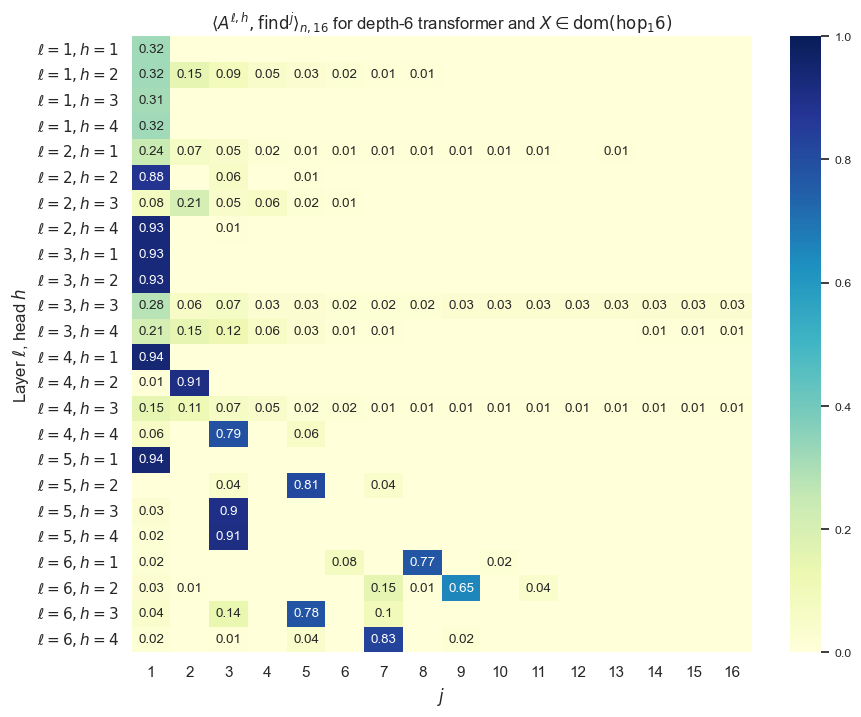

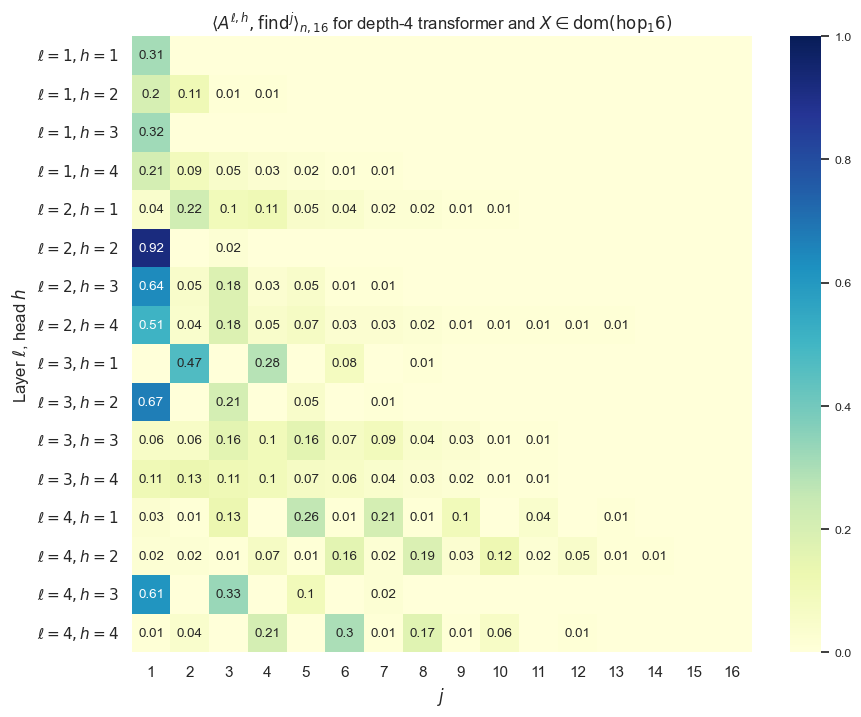

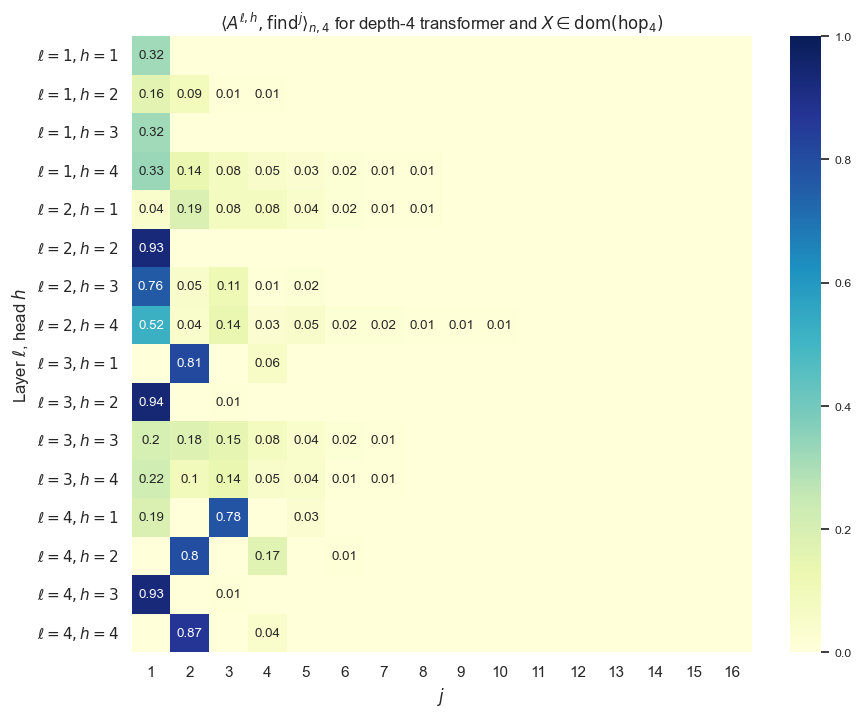

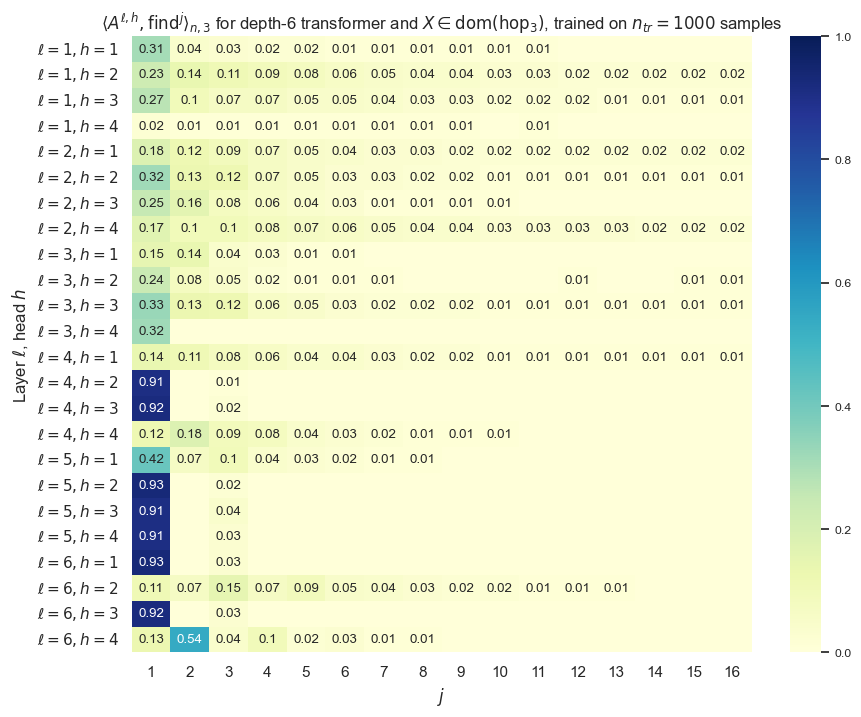

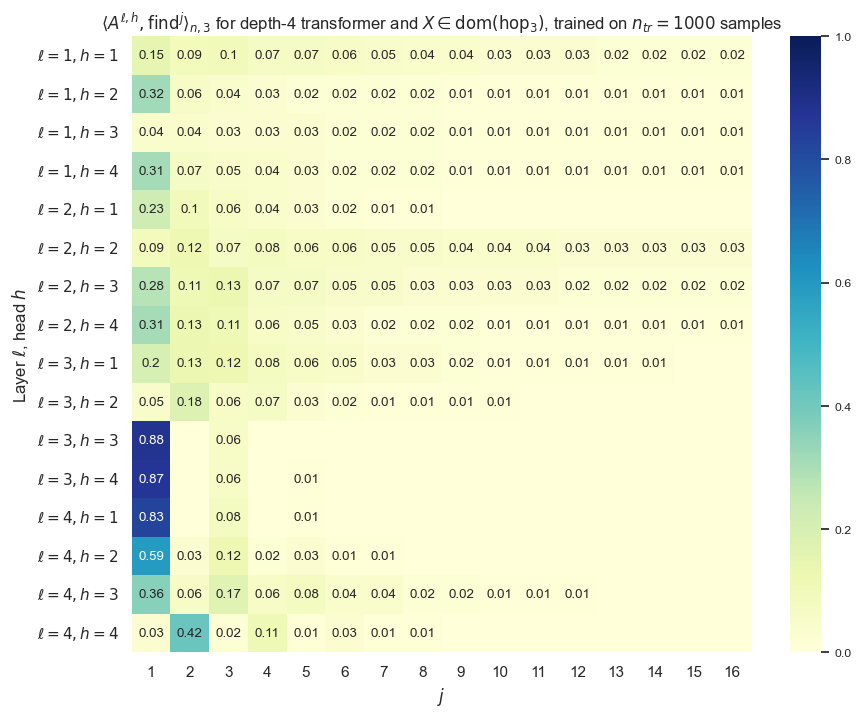

In [60]:
plot_attention_inner_products(6, 16, 4, -1)
plot_attention_inner_products(4, 16, 4, -1)
plot_attention_inner_products(4, 4, 4, -1)
plot_attention_inner_products(6, 3, 4, 1000)
plot_attention_inner_products(4, 3, 4, 1000)

### Interactive visualization of inner product alignments

In [61]:
# same as plot_attention_inner_products, but let the number of hops, the number of samples, the depth, and the width be sliders

depth_widget = widgets.IntSlider(min=2, max=6, step=1, value=6, description='Depth L:')
width_widget = widgets.IntSlider(min=4, max=8, step=4, value=4, description='Heads H:')
samples_widget = widgets.Dropdown(options=[1000, 3000, 10000, -1], value=-1, description='Trn. sample:')
h_widget = widgets.IntSlider(min=0, max=16, step=1, value=16, description='hop_k:')
interactive_plot = widgets.interactive(plot_attention_inner_products, depth=depth_widget, h=h_widget, width=width_widget, samples=samples_widget)
display(interactive_plot)


interactive(children=(IntSlider(value=6, description='Depth L:', max=6, min=2), IntSlider(value=16, descriptio…

## Plots of most common alignments

For a transformer of fixed depth $D$, shows how the alignment of each head changes with the task $h$. Color represents the hop mapped to and opacity represents the size of the inner product.

In [68]:
def plot_max_ips(depth, width, samples):
    
    key = (depth, width, samples)
    if key not in models:
        print("Model not found")
    else:
        argmax_inner_product = {}
        argmax_inner_product_means = {}
        for h in range(1, 17):
            for head in range(width):
                for layer in range(depth):
                    argmax_inner_product_means[(h, key, head, layer)] = 0
                    for h2 in range(1, 17):
                        if inner_product_means[(h, key, head, layer, h2)] > argmax_inner_product_means[(h, key, head, layer)]:
                            argmax_inner_product_means[(h, key, head, layer)] = inner_product_means[(h, key, head, layer, h2)]
                            argmax_inner_product[(h, key, head, layer)] = h2
        fig, ax = plt.subplots(figsize=(10, 10))
        aip = np.array([[argmax_inner_product[(h, key, head, layer)] for h in range(1, 17)] for layer in range(depth) for head in range(width)])
        im = sns.heatmap(
            aip, annot=aip, annot_kws={'color': 'g'}, 
            alpha=[[min(1, argmax_inner_product_means[(h, key, head, layer)]) for h in range(1, 17)] for layer in range(depth) for head in range(width)],
            cmap='plasma', vmin=1, vmax=16, cbar=False, ax=ax)

        tick_labels = range(1, 17)
        ax.set_xticklabels(tick_labels)
        ax.set_yticklabels([r"$\ell = {layer}, h= {head}$".format(layer =layer+1, head=head+1) for layer in range(depth) for head in range(width)])
        for tick in ax.get_yticklabels():
            tick.set_rotation(0)
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)

        ax.set_xlabel(r"$k$")
        ax.set_ylabel(r"Layer $\ell$, head $h$")

        title = r"$\mathrm{{argmax}}_j \langle A^{{\ell, h}}, \mathrm{{find}}^j\rangle_{{n, k}}$ for depth-{depth} transformer and $X \in \mathrm{{dom}}(\mathrm{{hop}}_{{k}})$".format(
            depth=depth, n=num_samples)
        
        ax.set_title(title)
        
        h_vals = np.array([range(1, 17)]).T
        cmap_ax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
        cmap_ax.imshow(h_vals, cmap='plasma')
        cmap_ax.set_xticks([])
        cmap_ax.set_yticks(range(16))
        cmap_ax.set_yticklabels(range(1,17))
        cmap_ax.set_title(r"$j$")

        plt.show()


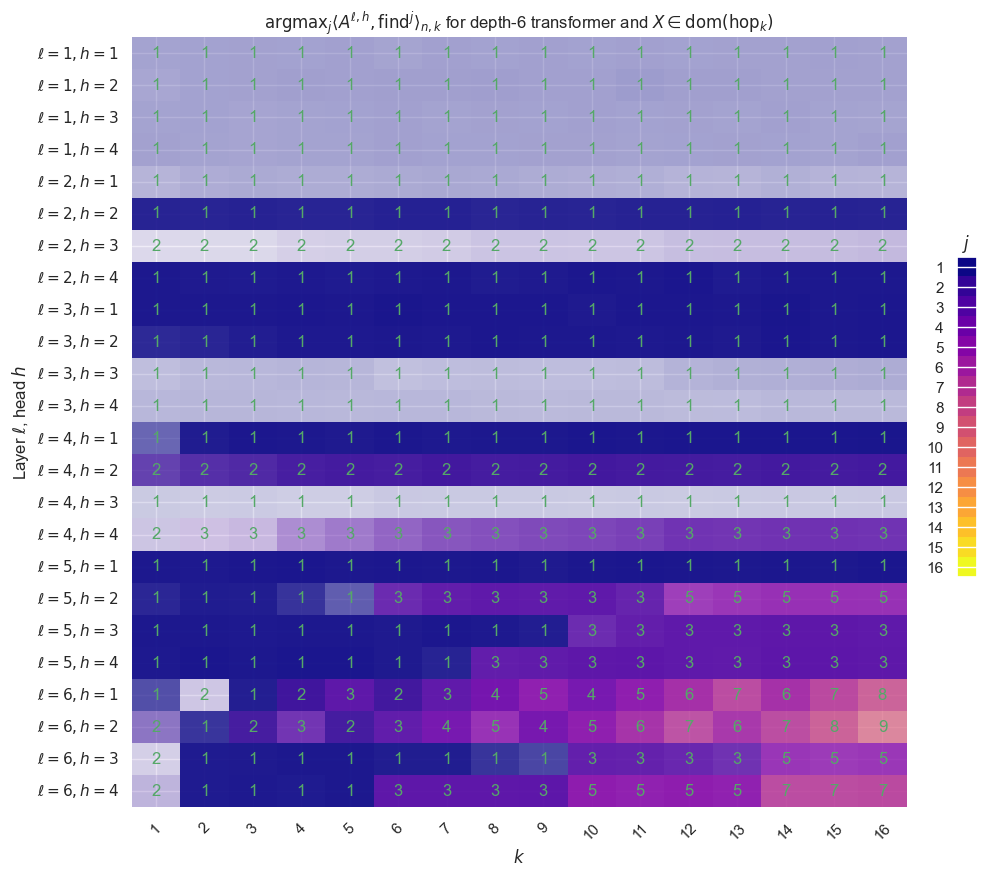

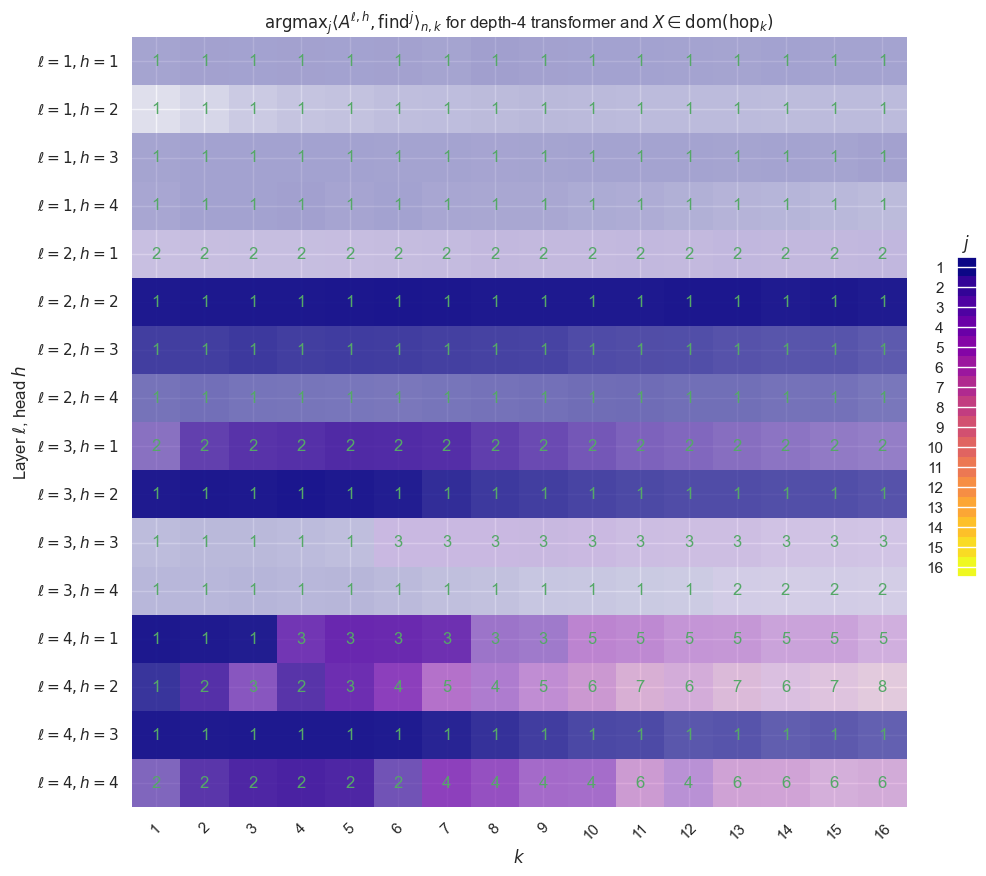

In [69]:
plot_max_ips(6, 4, -1)
plot_max_ips(4, 4, -1)

In [70]:
# same as plot_max_ips, but let the number of samples, the depth, and the width be sliders
depth_widget = widgets.IntSlider(min=2, max=6, step=1, value=6, description='Depth L:')
width_widget = widgets.IntSlider(min=4, max=8, step=4, value=4, description='Heads H:')
samples_widget = widgets.Dropdown(options=[1000, 3000, 10000, -1], value=-1, description='Trn. sample:')
interactive_plot = widgets.interactive(plot_max_ips, depth=depth_widget, width=width_widget, samples=samples_widget)
display(interactive_plot)


interactive(children=(IntSlider(value=6, description='Depth L:', max=6, min=2), IntSlider(value=4, description…